In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import json 
import re
import pandas as pd

In [2]:
with open('data/chunked_data/gdpr_clean.json') as f: 
    gdpr_clean = json.load(f)

In [3]:
originating_article = []
referenced_articles = []

for k in gdpr_clean.keys():
    if k != 'Legislative acts':
        for art in gdpr_clean[k].keys():
            relevant_text = gdpr_clean[k][art]
            articles_referenced = re.findall(r'article [0-9]+', relevant_text)
            originating_article+=[art]*len(articles_referenced)
            referenced_articles+=articles_referenced
        
network_df = pd.DataFrame({'origin':originating_article, 'reference':referenced_articles})
mapping_dict = {subk:subk[:subk.find('-')].strip().lower() for k in gdpr_clean.keys() for subk in gdpr_clean[k].keys() if k != 'Legislative acts'}
network_df['origin'] = network_df['origin'].map(mapping_dict)
mapping_dict_ref = {i:i[i.find(' '):].strip() for i in network_df['reference']}
mapping_dict_or = {i:i[i.find(' '):].strip() for i in network_df['origin']}
network_df['graph_origin'] = network_df['origin'].map(mapping_dict_or)
network_df['graph_reference'] = network_df['reference'].map(mapping_dict_ref)
print('DF Shape:', network_df.shape)
network_df.head()

DF Shape: (285, 4)


,origin,reference,graph_origin,graph_reference
0,article 2,article 98,2,98
1,article 4,article 27,4,27
2,article 4,article 51,4,51
3,article 4,article 1,4,1
4,article 5,article 89,5,89


In [4]:
graph = nx.from_pandas_edgelist(network_df, source='graph_origin', target='graph_reference', create_using=nx.DiGraph())

In [5]:
inverted_dict = {subk[subk.find('e')+1:subk.find('-')].strip().lower():k for k in gdpr_clean.keys() for subk in gdpr_clean[k].keys() if k != 'Legislative acts'}
color_dict = {'General provisions':'red', 
              'Principles':'coral', 
              'Rights of the data subject':'peru', 
              'Controller and processor':'orange', 
              'Transfers of personal data to third countries or international organisations':'gold', 
              'Independent supervisory authorities':'olivedrab', 
              'Cooperation and consistency':'lawngreen', 
              'Remedies, liability and penalties':'lime', 
              'Provisions relating to specific processing situations':'turquoise', 
              'Delegated acts and implementing acts':'aqua', 
              'Final provisions':'royalblue'}

color_l = [color_dict[inverted_dict[n]] for n in graph]

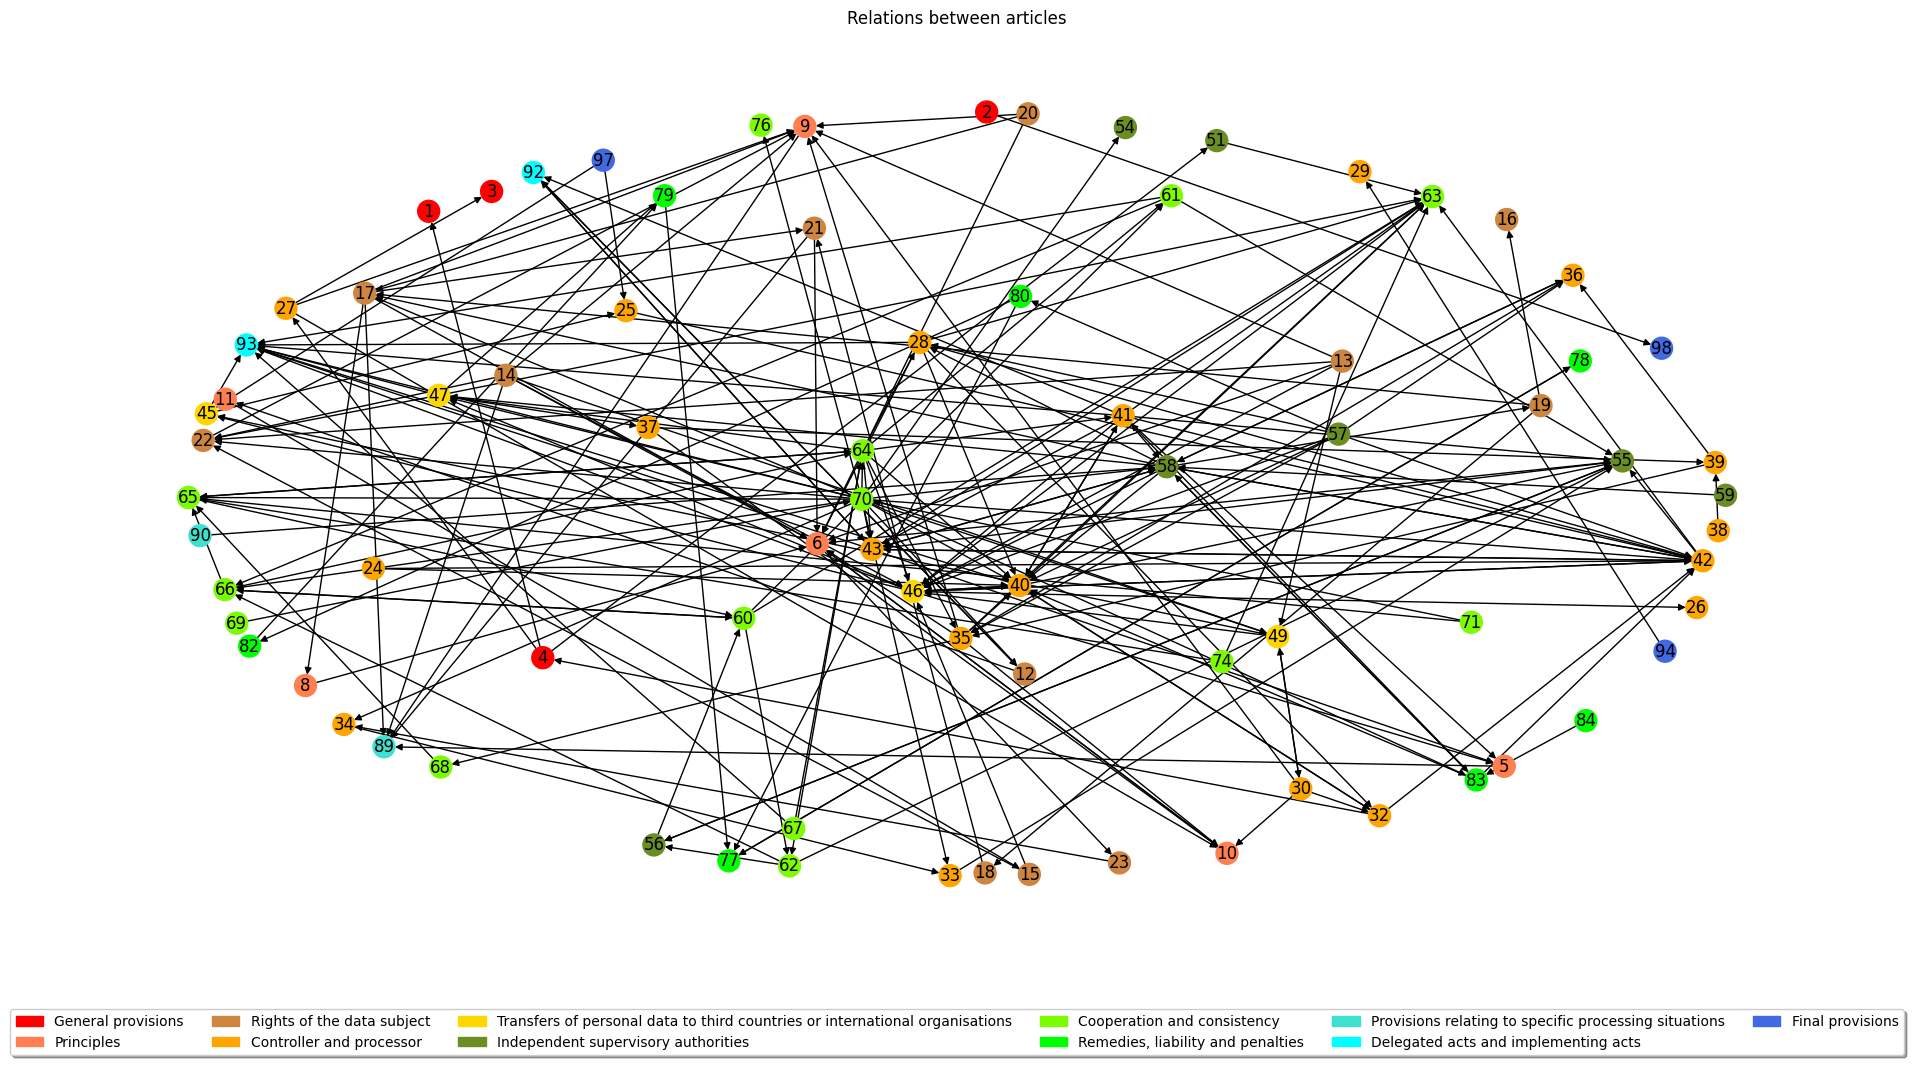

In [6]:
fig, ax = plt.subplots(figsize=(24,12))
ax.set_title('Relations between articles')
pos = nx.spring_layout(graph, k=6, iterations=300, seed=42)
nx.draw(graph, pos=pos, ax=ax, node_size=250, with_labels=True, node_color=color_l)
handles_l = [mpatches.Patch(color=color_dict[k], label=k) for k in gdpr_clean.keys() if k != 'Legislative acts']
plt.legend(handles=handles_l, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=6)
plt.show()

In [11]:
mapping_dict_inv = {v:k for k, v in mapping_dict.items()}

in_degrees_dict = dict(graph.in_degree)
top_5_most_cited_articles = sorted(in_degrees_dict, key=in_degrees_dict.get, reverse=True)[:5]
print('The top 5 most cited articles are:')
for i in top_5_most_cited_articles:
    print(mapping_dict_inv[f'article {i}'], '--->', in_degrees_dict[i], 'citations')
    
out_degrees_dict = dict(graph.out_degree)
top_5_most_citing_articles = sorted(out_degrees_dict, key=out_degrees_dict.get, reverse=True)[:5]
print('\nThe top 5 articles citing the most others are:')
for i in top_5_most_citing_articles:
    print(mapping_dict_inv[f'article {i}'], '--->', out_degrees_dict[i], 'citations')
    
print('\nNetwork Density:', round(nx.density(graph), 2))

page_rank_dict = dict(nx.pagerank(graph))
top_5_ranked_articles = sorted(page_rank_dict, key=page_rank_dict.get, reverse=True)[:5]
print('\nThe top 5 Page Rank Nodes are:')
for i in top_5_ranked_articles:
    print(mapping_dict_inv[f'article {i}'], '---> with value:', round(page_rank_dict[i],3))

The top 5 most cited articles are:
Article 40 - Codes of conduct ---> 11 citations
Article 42 - Certification ---> 11 citations
Article 63 - Consistency mechanism ---> 11 citations
Article 6 - Lawfulness of processing ---> 10 citations
Article 46 - Transfers subject to appropriate safeguards ---> 10 citations

The top 5 articles citing the most others are:
Article 70 - Tasks of the Board ---> 18 citations
Article 58 - Powers ---> 10 citations
Article 41 - Monitoring of approved codes of conduct ---> 10 citations
Article 64 - Opinion of the Board ---> 10 citations
Article 46 - Transfers subject to appropriate safeguards ---> 8 citations

Network Density: 0.03

The top 5 Page Rank Nodes are:
Article 6 - Lawfulness of processing ---> with value: 0.076
Article 55 - Competence ---> with value: 0.058
Article 77 - Right to lodge a complaint with a supervisory authority ---> with value: 0.052
Article 78 - Right to an effective judicial remedy against a supervisory authority ---> with value: 0.

In [35]:
communities = nx.community.louvain_communities(graph, seed=42)
print(f'Overall, there are {len(communities)} communities')

Overall, there are 9 communities


In [47]:
idx = 0
community_id = []
community_members = []
for i in communities:
    temp_l = []
    for art in i:
        temp_l.append(mapping_dict_inv[f'article {art}'])
    community_members.append(temp_l)
    community_id.append(idx)
    idx+=1 
community_df = pd.DataFrame({'Community Id': community_id})
community_df['Members']='a'
for i in range(community_df.shape[0]):
    community_df.at[i, 'Members']=community_members[i]
styled_df = community_df.style.set_properties(subset=['Members'], **{'height': '60px', 'width':'5000px'})
styled_df

,Community Id,Members
0,0,"['Article 98 - Review of other Union legal acts on data protection', 'Article 2 - Material scope']"
1,1,"['Article 4 - Definitions', 'Article 51 - Supervisory authority', 'Article 3 - Territorial scope', 'Article 27 - Representatives of controllers or processors not established in the Union', 'Article 1 - Subject-matter and objectives']"
2,2,"['Article 78 - Right to an effective judicial remedy against a supervisory authority', 'Article 39 - Tasks of the data protection officer', 'Article 37 - Designation of the data protection officer', 'Article 80 - Representation of data subjects', 'Article 47 - Binding corporate rules', 'Article 77 - Right to lodge a complaint with a supervisory authority', 'Article 38 - Position of the data protection officer', 'Article 82 - Right to compensation and liability', 'Article 79 - Right to an effective judicial remedy against a controller or processor']"
3,3,"['Article 18 - Right to restriction of processing', 'Article 21 - Right to object', 'Article 10 - Processing of personal data relating to criminal convictions and offences', 'Article 20 - Right to data portability', 'Article 17 - Right to erasure (‘right to be forgotten’)', 'Article 22 - Automated individual decision-making, including profiling', ""Article 8 - Conditions applicable to child's consent in relation to information society services"", 'Article 14 - Information to be provided where personal data have not been obtained from the data subject', 'Article 6 - Lawfulness of processing', 'Article 23 - Restrictions', 'Article 89 - Safeguards and derogations relating to processing for archiving purposes in the public interest,', 'Article 13 - Information to be provided where personal data are collected from the data subject', 'Article 30 - Records of processing activities', 'Article 35 - Data protection impact assessment', 'Article 9 - Processing of special categories of personal data', 'Article 49 - Derogations for specific situations', 'Article 19 - Notification obligation regarding rectification or erasure of personal data or restriction of', 'Article 16 - Right to rectification']"
4,4,"['Article 15 - Right of access by the data subject', 'Article 11 - Processing which does not require identification', 'Article 12 - Transparent information, communication and modalities for the exercise of the rights of the data', 'Article 92 - Exercise of the delegation']"
5,5,"['Article 97 - Commission reports', 'Article 45 - Transfers on the basis of an adequacy decision', 'Article 25 - Data protection by design and by default']"
6,6,"['Article 46 - Transfers subject to appropriate safeguards', 'Article 40 - Codes of conduct', 'Article 24 - Responsibility of the controller', 'Article 84 - Penalties', 'Article 59 - Activity reports', 'Article 93 - Committee procedure', 'Article 57 - Tasks', 'Article 32 - Security of processing', 'Article 5 - Principles relating to processing of personal data', 'Article 63 - Consistency mechanism', 'Article 42 - Certification', 'Article 41 - Monitoring of approved codes of conduct', 'Article 26 - Joint controllers', 'Article 28 - Processor', 'Article 83 - General conditions for imposing administrative fines', 'Article 36 - Prior consultation', 'Article 90 - Obligations of secrecy', 'Article 43 - Certification bodies', 'Article 58 - Powers']"
7,7,"['Article 55 - Competence', 'Article 33 - Notification of a personal data breach to the supervisory authority', 'Article 61 - Mutual assistance', 'Article 56 - Competence of the lead supervisory authority', 'Article 54 - Rules on the establishment of the supervisory authority', 'Article 66 - Urgency procedure', 'Article 65 - Dispute resolution by the Board', 'Article 69 - Independence', 'Article 67 - Exchange of information', 'Article 60 - Cooperation between the lead supervisory authority and the other supervisory authorities', 'Article 34 - Communication of a personal data breach to the data subject', 'Article 68 - European Data Protection Board'

In [8]:
network_df['origin_chapter'] = network_df['graph_origin'].map(inverted_dict)
network_df['destination_chapter'] = network_df['graph_reference'].map(inverted_dict)
grouped_network_df = network_df.groupby(['origin_chapter', 'destination_chapter'])[['origin']].count().reset_index().rename({'origin':'number_of_connections'}, axis=1)
grouped_graph = nx.from_pandas_edgelist(grouped_network_df, source='origin_chapter', target='destination_chapter', edge_attr='number_of_connections', create_using=nx.DiGraph())

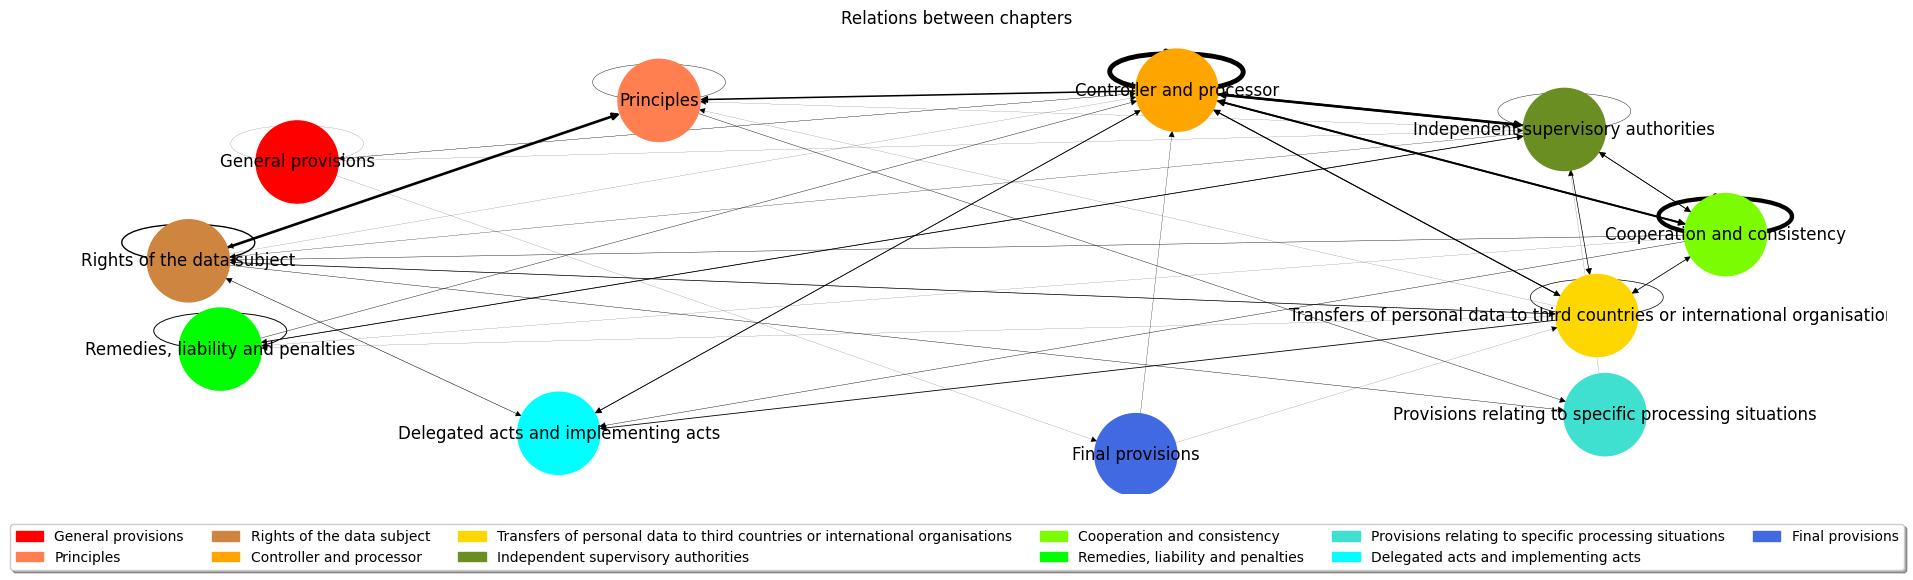

In [9]:
fig, ax = plt.subplots(figsize=(24,6))
ax.set_title('Relations between chapters')
pos = nx.spring_layout(grouped_graph, k=15, iterations=300, seed=42)
color_l_group = [color_dict[n] for n in grouped_graph]
widths = [grouped_graph[e[0]][e[1]]['number_of_connections']/10 for e in grouped_graph.edges()]
nx.draw(grouped_graph, pos=pos, ax=ax, node_size=3500, with_labels=True, node_color=color_l_group, width=widths)
handles_l = [mpatches.Patch(color=color_dict[k], label=k) for k in gdpr_clean.keys() if k != 'Legislative acts']
plt.legend(handles=handles_l, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=6)
plt.show()